In [8]:
# BSD 3-Clause License
#
# Copyright (c) 2023, Princeton University
#
# Redistribution and use in source and binary forms, with or without
# modification, are permitted provided that the following conditions are met:
#
# 1. Redistributions of source code must retain the above copyright notice, this
#    list of conditions and the following disclaimer.
#
# 2. Redistributions in binary form must reproduce the above copyright notice,
#    this list of conditions and the following disclaimer in the documentation
#    and/or other materials provided with the distribution.
#
# 3. Neither the name of the copyright holder nor the names of its
#    contributors may be used to endorse or promote products derived from
#    this software without specific prior written permission.
#
# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
# AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
# IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
# DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
# FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
# DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
# SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
# CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
# OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
# OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

In [9]:
import supply_chain_model as scm
import numpy as np
import matplotlib.pyplot as plt

In [10]:
# Apple A11 example
# Note that current datasets are updated from the data used in the paper
# especially wafer production rates, transistor density estimates, 
# wafer costs, and mask costs

a11_num_final_chips = 10e6
a11_total_transistors = 4.6e9
a11_unique_transistors = 514e6
a11_num_engineers = 100
a11_tapeout_parallel_factor = 0.6
a11_fab_queue_weeks = 0
a11_dies_per_package = 1
a11_pack_test_ratio = 0.1

In [11]:
a11_nodes_v = [scm.PN_65_INDEX, scm.PN_40_INDEX, scm.PN_28_INDEX, \
               scm.PN_20_INDEX, scm.PN_14_INDEX, scm.PN_7_INDEX, scm.PN_5_INDEX]
a11_ttm_cost_v = []

# calc_ttm_cost returns a tuple of (tapeout_time, fab_queue_time, fab_prod_time, osat_time, cost)
for node_i in a11_nodes_v:
    wafer_rate_hour_i = scm.wafers_prod_per_hour[node_i]
    ttm_cost = scm.calc_ttm_cost_single_process(node_i, a11_num_final_chips, a11_total_transistors, \
                                  a11_unique_transistors, a11_num_engineers, \
                                  a11_tapeout_parallel_factor, a11_fab_queue_weeks, \
                                  wafer_rate_hour_i, a11_dies_per_package, a11_pack_test_ratio)
    a11_ttm_cost_v.append(ttm_cost)

In [12]:
a11_cas_v = []
diff_v = np.linspace(0.05, 1, 100)

for node_i in a11_nodes_v:
    ttm_v = []
    wafer_prod_rate_v = []
    for j in diff_v:
        wafer_rate_hour_i = scm.wafers_prod_per_hour[node_i] * j
        ttm = scm.calc_ttm_cost_single_process(node_i, a11_num_final_chips, a11_total_transistors, \
                                  a11_unique_transistors, a11_num_engineers, \
                                  a11_tapeout_parallel_factor, a11_fab_queue_weeks, \
                                  wafer_rate_hour_i, a11_dies_per_package, a11_pack_test_ratio)
        
        wafer_prod_rate_v.append(wafer_rate_hour_i)
        ttm_v.append(ttm[0] + ttm[1] + ttm[2] + ttm[3])
    
    cas_v = scm.calc_cas_single_process(ttm_v, wafer_prod_rate_v)
    a11_cas_v.append(cas_v)

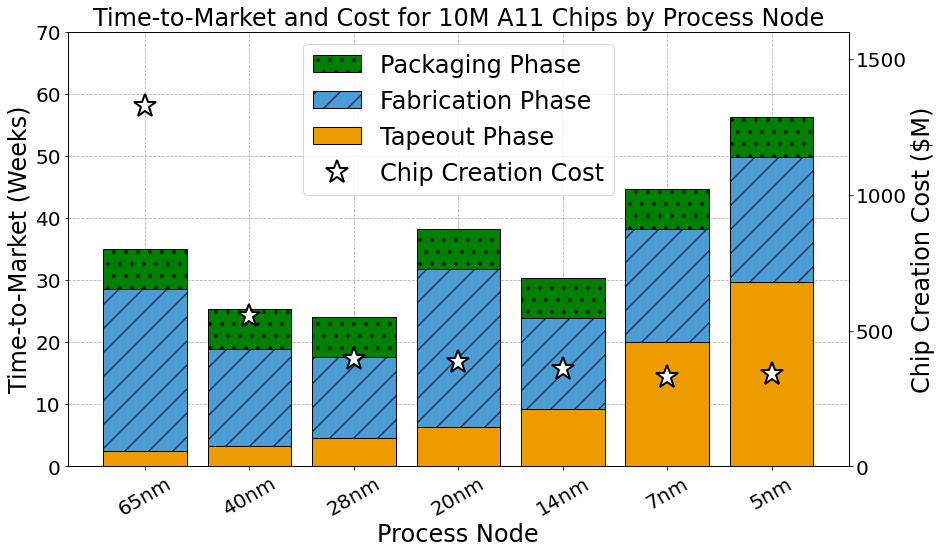

In [13]:
a11_tapeout_time_v = []
a11_fab_time_v = []
a11_osat_time_v = []
a11_cost_v = []
a11_nodes_i = range(len(a11_nodes_v))

for i in a11_nodes_i:
    a11_tapeout_time, a11_fab_queue_time, a11_fab_prod_time, a11_osat_time, a11_cost = a11_ttm_cost_v[i]
    a11_tapeout_time_v.append(a11_tapeout_time)
    a11_fab_time_v.append(a11_fab_queue_time + a11_fab_prod_time)
    a11_osat_time_v.append(a11_osat_time)
    a11_cost_v.append(a11_cost)

a11_tapeout_time_v = np.array(a11_tapeout_time_v)
a11_fab_time_v = np.array(a11_fab_time_v)
a11_osat_time_v = np.array(a11_osat_time_v)
a11_cost_v = np.array(a11_cost_v)
a11_labels = [f'{scm.process_nodes[node]}nm' for node in a11_nodes_v]
bar_width = 0.8

plt.rcParams["figure.figsize"] = (14,8)

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.bar(a11_nodes_i, a11_osat_time_v, bar_width, bottom=a11_fab_time_v+a11_tapeout_time_v, color='g', edgecolor='k', zorder=3, label="Packaging Phase", hatch='.')
ax1.bar(a11_nodes_i, a11_fab_time_v, bar_width, bottom=a11_tapeout_time_v, color='#4B9CD4', edgecolor='k', zorder=3, label="Fabrication Phase", hatch='/')
ax1.bar(a11_nodes_i, a11_tapeout_time_v, bar_width, color='#ee9b00', edgecolor='k', zorder=3, label="Tapeout Phase")

ax2 = ax1.twinx()
ax2.plot(a11_nodes_i, a11_cost_v / 1e6, 'w*', \
         markersize=24, markeredgecolor='k', markeredgewidth=2, zorder=3, label="Chip Creation Cost")

ax1.set_ylim(0, 70)
ax1.set_ylabel('Time-to-Market (Weeks)', fontsize=24)
ax1.set_xticks(a11_nodes_i)
ax1.set_xticklabels(a11_labels, rotation=30, fontsize=20)
ax1.set_xlabel('Process Node', fontsize=24)
ax1.tick_params(axis='y', labelsize=20)
ax1.grid(True, zorder=0., ls="--")

ax2.set_ylabel('Chip Creation Cost ($M)', fontsize=24)
ax2.set_yticks([0, 500, 1000, 1500])
ax2.set_ylim(0, 1600)
ax2.tick_params(axis='y', labelsize=20)

fig.legend(loc="upper center", bbox_to_anchor=(0.5, 1.0), bbox_transform=ax1.transAxes, fontsize=24)
plt.title('Time-to-Market and Cost for 10M A11 Chips by Process Node', fontsize=24)

plt.savefig('figs/a11_ttm_cost.svg', bbox_inches='tight')
plt.show()

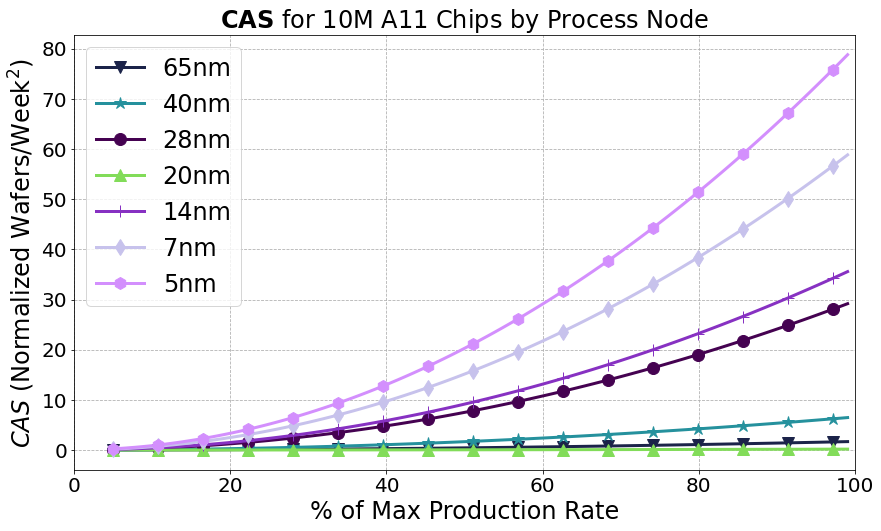

In [14]:
a11_cas_x = diff_v[:-1] * 100
marker_arr = ['v', '*', 'o', '^', '+', 'd', 'h']
color_arr = ['#1b2349', '#25919d', '#450251', '#82dc59', '#8731c2', '#c7c2ec', '#d38ffd']
marker_index = 0

for i in a11_nodes_i:
    plt.plot(a11_cas_x, a11_cas_v[i] / 1e1, label=a11_labels[i], marker=marker_arr[i],
             color=color_arr[i], markevery=6, markersize=12, lw=3, zorder=3)

plt.title('$\mathbf{CAS}$ for 10M A11 Chips by Process Node', fontsize=24)
plt.xlabel('% of Max Production Rate', fontsize=24)
plt.xticks(fontsize=20)
plt.xlim(0, 100)
plt.ylabel('$CAS$ (Normalized Wafers/Week$^2$)', fontsize=24)
plt.yticks(fontsize=20)

plt.legend(fontsize=24)
plt.grid(True, zorder=0., ls="--")

plt.savefig('figs/a11_cas.svg', bbox_inches='tight')
plt.show()